__David Sivieri__  
__CSC8200 Health Informatics & EHealth Systems__  
__Final Project__  
__Feb 24, 2020__

## Data Modeling

In this notebook, I will attempt to create models that predict readmissions.  I will use two different types of classifiers: DecisionTreeClassifier and RandomForestClassifier.  

I will also try two different strategies for dealing with the imbalanced classes.  First I will try creating synthetic data for the minority class, then I will attempt to undersample the majority class.  Both will be compared to a stratified dummy classifier (guessing).  Precision, recall, and accuracy will all be generated.

In [32]:
import math
import sys
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RepeatedKFold
from scipy import stats

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier


import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.max_rows", 1000000)
pd.set_option("display.max_columns", 1000000)
pd.set_option("display.width", 1000000)
pd.set_option("display.max_colwidth", 1000000)
pd.set_option("display.max_info_columns", 1000)
np.set_printoptions(threshold=sys.maxsize)

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

In [33]:
%%HTML
<style type="text/css">
    table.dataframe td, table.dataframe th {
        border-style: solid;
        border: 1px solid lightgray;
    }
    tr:nth-child(even) {
        background: #eee;
    }
    th {
       background-color: lemonchiffon;
       color: black;
}
</style>

**This block of code provided by scikit-learn for the purpose of generating confusion matrices**

In [34]:
# Provided by https://scikit-learn.org/0.20/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.spring):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="black" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [35]:
df = pd.read_pickle("diabetic_data_processed.pkl")
df.head(5)

time_in_hospital  num_lab_procedures  num_procedures  num_medications  number_diagnoses  readmitted_less_30  imputed_age  num_med_changes  num_meds_total  all_hospitalizations  num_enc_to_date  race_AfricanAmerican  race_Asian  race_Caucasian  race_Hispanic  race_Other  race_unknown  gender_Female  gender_Male  admission_type_id_1  admission_type_id_2  admission_type_id_3  admission_type_id_4  admission_type_id_5  admission_type_id_6  admission_type_id_7  admission_type_id_8  discharge_disposition_id_1  discharge_disposition_id_10  discharge_disposition_id_12  discharge_disposition_id_13  discharge_disposition_id_14  discharge_disposition_id_15  discharge_disposition_id_16  discharge_disposition_id_17  discharge_disposition_id_18  discharge_disposition_id_2  discharge_disposition_id_22  discharge_disposition_id_23  discharge_disposition_id_24  discharge_disposition_id_25  discharge_disposition_id_27  discharge_disposition_id_28  discharge_disposition_id_3  discharge_disposition_id_4  discharge_disposition_id_5  discharge_disposition_id_6  discharge_disposition_id_7  discharge_disposition_id_8  discharge_disposition_id_9  admission_source_id_1  admission_source_id_10  admission_source_id_11  admission_source_id_13  admission_source_id_14  admission_source_id_17  admission_source_id_2  admission_source_id_20  admission_source_id_22  admission_source_id_25  admission_source_id_3  admission_source_id_4  admission_source_id_5  admission_source_id_6  admission_source_id_7  admission_source_id_8  admission_source_id_9  max_glu_serum_>200  max_glu_serum_>300  max_glu_serum_None  max_glu_serum_Norm  A1Cresult_>7  A1Cresult_>8  A1Cresult_None  A1Cresult_Norm  change_Ch  change_No  diabetesMed_No  diabetesMed_Yes
patient_nbr encounter_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
135         24437208              1.213758            1.735740        2.746235         2.102960          0.304807                   1    -0.679151         1.460352        1.968756             -0.775520        -0.545701                     0           0               1              0           0             0              1            0                    0                    1                    0                    0                    0                    0                    0                    0     

In [36]:
df.shape

(91679, 79)

# Modeling Through Undersampling Majority Class

In this section, I will attempt to predict readmissions using two different (but related) machine learning algorithms: decision trees and random forests.  This dataset has a problem, however, in that it is highly imbalanced.  11% of the encounters leads to a readmission and 89% do not.  If I were to train a ML algorithm with the set that unbalanced, it could produce a model highly biased toward no readmissions.  In order to deal with this, I will undersample the majority class.  As can be seen below, the training data has an equal 50/50 split between the two classes.  

The random forest performed somewhat better than the decision tree model, so I will analyze here further.  The random forest model trained with this data had an accuracy of 59.27% classifying the testing data.  Precision was 15.2% and recall was 60.4%.  So, the model was extremely imprecise as it had a very high number of falsely predicted readmits.  The recall was somewhat better in that the number of falsely predicted No_readmits was much lower than true readmits.

Of the three processes I tried, I think random forest with majority undersampling may hold the most promise.  It had the lowest % of false No_readmits, which I think for this type of problem is quite important.  These would be people the model predicted would not be re-admitted, but actually were.  If a hospital is penalized for this type of situation, I would think this type of model would be useful.



In [37]:
df_test = df.sample(frac=0.2)
X_test = df_test.drop("readmitted_less_30", axis=1)
y_test = df_test["readmitted_less_30"]


df_train = df.drop(df_test.index, axis=0)
X_train = df_train.drop("readmitted_less_30", axis=1)
y_train = df_train["readmitted_less_30"]
print('Pre-Resampled training class shape %s' % Counter(y_train))

rus = RandomUnderSampler()
X_train, y_train = rus.fit_sample(X_train, y_train)

print('Resampled training class shape %s' % Counter(y_train))

Pre-Resampled training class shape Counter({0: 65331, 1: 8012})
Resampled training class shape Counter({0: 8012, 1: 8012})


In [38]:
dtree_classifier = DecisionTreeClassifier()
dtree_classifier.fit(X_train, y_train)
y_test_predict = dtree_classifier.predict(X_test)
print("Accuracy of non-cross validated decision tree classifier (testing set): {:.2%}".format(dtree_classifier.score(X_test, y_test)))

Accuracy of non-cross validated decision tree classifier (testing set): 54.27%


In [46]:
# from IPython.display import SVG

# graph = Source(tree.export_graphviz(dtree_classifier, out_file=None, feature_names=X_train.columns, class_names=np.array(["No_Readmit", "Readmit"])))
# SVG(graph.pipe(format="svg"))

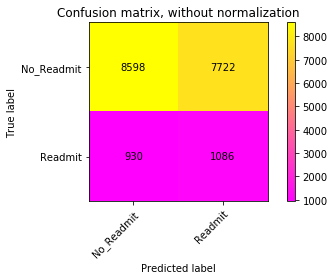

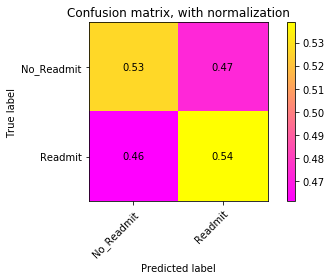

In [8]:
ax1 = plot_confusion_matrix(np.array(y_test), np.array(y_test_predict), classes=np.array(["No_Readmit", "Readmit"]), title="Confusion matrix, without normalization")
ax2 = plot_confusion_matrix(np.array(y_test), np.array(y_test_predict), classes=np.array(["No_Readmit", "Readmit"]), normalize=True, title="Confusion matrix, with normalization")

In [9]:
report_dict = classification_report(y_test, y_test_predict, target_names=np.array(["No_Readmit", "Readmit"]), output_dict=True)
pd.DataFrame(report_dict).transpose()

,precision,recall,f1-score,support
No_Readmit,0.902393,0.526838,0.665274,16320.000000
Readmit,0.123297,0.538690,0.200665,2016.000000
accuracy,0.528141,0.528141,0.528141,0.528141
macro avg,0.512845,0.532764,0.432970,18336.000000
weighted avg,0.816733,0.528141,0.614191,18336.000000


In [10]:
rand_frst_classifier = RandomForestClassifier()
rand_frst_classifier.fit(X_train, y_train)
y_test_predict = rand_frst_classifier.predict(X_test)
print("Accuracy of non-cross validated random forest (testing set): {:.2%}".format(rand_frst_classifier.score(X_test, y_test)))

Accuracy of non-cross validated random forrest (testing set): 58.58%


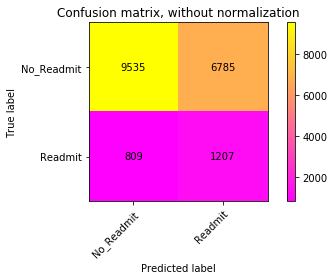

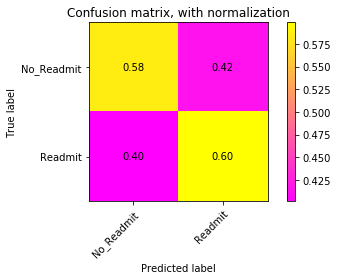

In [11]:
ax1 = plot_confusion_matrix(np.array(y_test), np.array(y_test_predict), classes=np.array(["No_Readmit", "Readmit"]), title="Confusion matrix, without normalization")
ax2 = plot_confusion_matrix(np.array(y_test), np.array(y_test_predict), classes=np.array(["No_Readmit", "Readmit"]), normalize=True, title="Confusion matrix, with normalization")

In [12]:
report_dict = classification_report(y_test, y_test_predict, target_names=np.array(["No_Readmit", "Readmit"]), output_dict=True)
pd.DataFrame(report_dict).transpose()

,precision,recall,f1-score,support
No_Readmit,0.921790,0.584252,0.715197,16320.000000
Readmit,0.151026,0.598710,0.241207,2016.000000
accuracy,0.585842,0.585842,0.585842,0.585842
macro avg,0.536408,0.591481,0.478202,18336.000000
weighted avg,0.837047,0.585842,0.663082,18336.000000


In [13]:
X = df.drop("readmitted_less_30", axis=1)
y = df["readmitted_less_30"]

rus = RandomUnderSampler()
X, y = rus.fit_sample(X, y)

tests = [(5, 4), (2, 10), (10, 2), (10, 10)]

dTreeScores = []
rForestScores = []

for folds, repeats in tests:

    print("Working on:", "Folds:", folds, "Repeats:", repeats, "...")
    rkf = RepeatedKFold(n_splits=folds, n_repeats=repeats)

    dTree = DecisionTreeClassifier()
    rForest = RandomForestClassifier()

    dTreeScores.append(cross_val_score(dTree, X, y, cv=rkf, n_jobs=-1))
    rForestScores.append(cross_val_score(rForest, X, y, cv=rkf, n_jobs=-1))

Working on: Folds: 5 Repeats: 4 ...
Working on: Folds: 2 Repeats: 10 ...
Working on: Folds: 10 Repeats: 2 ...
Working on: Folds: 10 Repeats: 10 ...


In [14]:
dTreeScores_arr = np.array(dTreeScores)
rForestScores_arr = np.array(rForestScores)

df_list = []
for i, tup in enumerate(tests):
    df_list.append([tup[0], tup[1], dTreeScores_arr[i].mean(), dTreeScores_arr[i].std(), rForestScores_arr[i].mean(), rForestScores_arr[i].std()])

P = pd.DataFrame(df_list, columns=["Folds", "Repeats", "Dtree_Acc_mean", "DTree_Acc-stdDev", "RForest_Acc-mean", "RForest_Acc-stdDev"]).set_index(["Folds", "Repeats"])
P.round(5)

Dtree_Acc_mean  DTree_Acc-stdDev  RForest_Acc-mean  RForest_Acc-stdDev
Folds Repeats                                                                        
5     4               0.54027           0.00716           0.59160             0.00670
2     10              0.53638           0.00562           0.59045             0.00352
10    2               0.53600           0.01254           0.59394             0.00861
      10              0.53511           0.01093           0.59322             0.01078

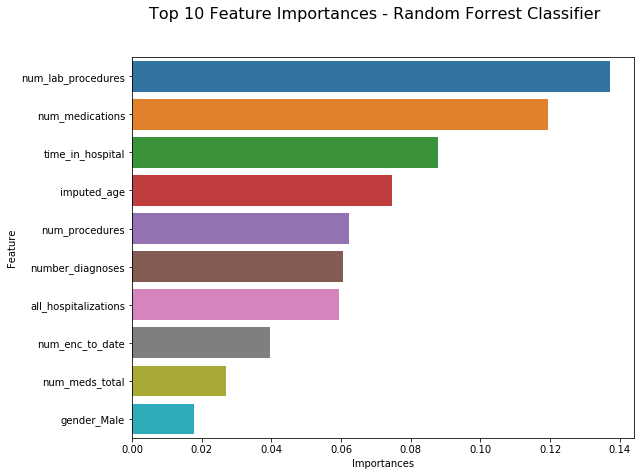

In [15]:
feature_names_ser = pd.Series(X_train.columns).rename("Feature")
feature_imports_ser = pd.Series(rand_frst_classifier.feature_importances_).rename("Importances")
important_features = feature_names_ser.to_frame().join(feature_imports_ser).sort_values(by="Importances", ascending=False).set_index("Feature").iloc[:10]

fig, ax = plt.subplots(1, figsize=(9, 7))

sns.barplot(x="Importances", y=important_features.index, ax=ax, data=important_features)

fig.suptitle("Top 10 Feature Importances - Random Forrest Classifier", fontsize=16)

plt.show()

# Model With Synthetic Data

In this section, I perform modeling using a technique called synthetic minority over-sampling.  This technique actually creates artificial training for the minority class.  It using sampling techniques to create minority class data with similarm but not exactly the same feature values.  If you look, at the example below, after SMOTE was applied, I had a perfectly balanced data-set with many more data points than my previous example.  

I decided to try this more as a learning exercise, as I am not completely comfortable with the statistical soundness of using this technique.  The results were interesting.  Accuracy was much higher than the undersampling case, but precision and recall were quite poor.  These seems like an interesting technqiue, but as configured here, I don't feel that it is useful.

In [16]:
df_test = df.sample(frac=0.2)
X_test = df_test.drop("readmitted_less_30", axis=1)
y_test = df_test["readmitted_less_30"]

df_train = df.drop(df_test.index, axis=0)
X_train = df_train.drop("readmitted_less_30", axis=1)
y_train = df_train["readmitted_less_30"]
print("Pre-Resampled training class shape %s" % Counter(y_train))

smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

print("Resampled training class shape %s" % Counter(y_train))

Pre-Resampled training class shape Counter({0: 65392, 1: 7951})
Resampled training class shape Counter({1: 65392, 0: 65392})


In [17]:
dtree_classifier = DecisionTreeClassifier()
dtree_classifier.fit(X_train, y_train)
y_test_predict = dtree_classifier.predict(X_test)
print("Accuracy of non-cross validated decision tree classifier (testing set): {:.2%}".format(dtree_classifier.score(X_test, y_test)))

Accuracy of non-cross validated decision tree classifier (testing set): 78.82%


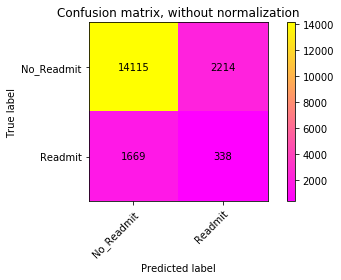

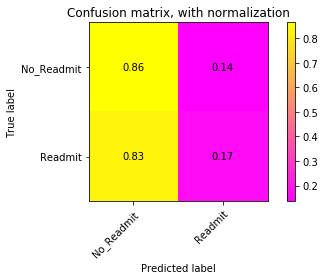

In [18]:
ax1 = plot_confusion_matrix(np.array(y_test), np.array(y_test_predict), classes=np.array(["No_Readmit", "Readmit"]), title="Confusion matrix, without normalization")
ax2 = plot_confusion_matrix(np.array(y_test), np.array(y_test_predict), classes=np.array(["No_Readmit", "Readmit"]), normalize=True, title="Confusion matrix, with normalization")

In [19]:
report_dict = classification_report(y_test, y_test_predict, target_names=np.array(["No_Readmit", "Readmit"]), output_dict=True)
pd.DataFrame(report_dict).transpose()

,precision,recall,f1-score,support
No_Readmit,0.894260,0.864413,0.879083,16329.000000
Readmit,0.132445,0.168411,0.148278,2007.000000
accuracy,0.788231,0.788231,0.788231,0.788231
macro avg,0.513353,0.516412,0.513681,18336.000000
weighted avg,0.810874,0.788231,0.799092,18336.000000


In [20]:
rand_frst_classifier = RandomForestClassifier()
rand_frst_classifier.fit(X_train, y_train)
y_test_predict = rand_frst_classifier.predict(X_test)
print("Accuracy of non-cross validated random forrest (testing set): {:.2%}".format(rand_frst_classifier.score(X_test, y_test)))

Accuracy of non-cross validated random forrest (testing set): 88.59%


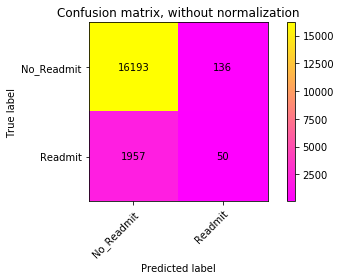

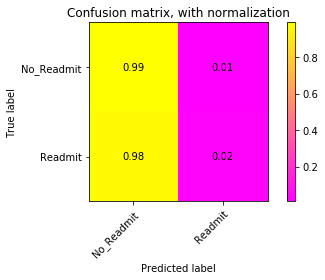

In [21]:
ax1 = plot_confusion_matrix(np.array(y_test), np.array(y_test_predict), classes=np.array(["No_Readmit", "Readmit"]), title="Confusion matrix, without normalization")
ax2 = plot_confusion_matrix(np.array(y_test), np.array(y_test_predict), classes=np.array(["No_Readmit", "Readmit"]), normalize=True, title="Confusion matrix, with normalization")

In [22]:
report_dict = classification_report(y_test, y_test_predict, target_names=np.array(["No_Readmit", "Readmit"]), output_dict=True)
pd.DataFrame(report_dict).transpose()

,precision,recall,f1-score,support
No_Readmit,0.892176,0.991671,0.939296,16329.000000
Readmit,0.268817,0.024913,0.045600,2007.000000
accuracy,0.885853,0.885853,0.885853,0.885853
macro avg,0.580497,0.508292,0.492448,18336.000000
weighted avg,0.823945,0.885853,0.841475,18336.000000


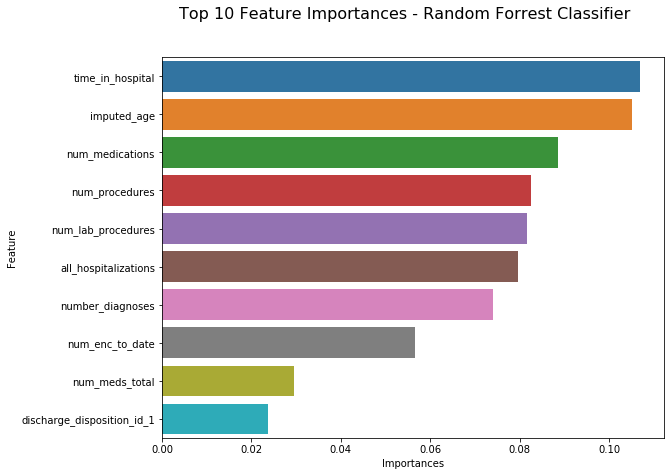

In [23]:
feature_names_ser = pd.Series(X_train.columns).rename("Feature")
feature_imports_ser = pd.Series(rand_frst_classifier.feature_importances_).rename("Importances")
important_features = feature_names_ser.to_frame().join(feature_imports_ser).sort_values(by="Importances", ascending=False).set_index("Feature").iloc[:10]

fig, ax = plt.subplots(1, figsize=(9, 7))

sns.barplot(x="Importances", y=important_features.index, ax=ax, data=important_features)

fig.suptitle("Top 10 Feature Importances - Random Forrest Classifier", fontsize=16)

plt.show()

# Dummy Classifier Baseline

Finally, I wanted to try a completely naive dummy classifier and compare results.  I decided to use a stratified guessing classifier.  All it does is perform a weighted random guess biased toward the training set class distribution.  So, if 89% of the training class is no_readmit, then 89% of the predictions will be no_readmit.  It is interesting to see that it has the highest accuracy of all the classifiers, but the precision and recall for readmit were very poor.

In [24]:
X = df.drop("readmitted_less_30", axis=1)
y = df["readmitted_less_30"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [25]:
dummy_clf.score(X_test, y_test)

0.8068826352530541

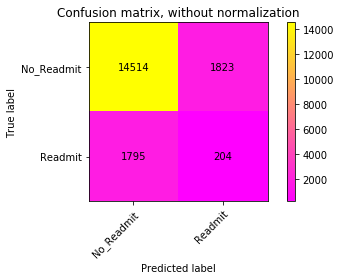

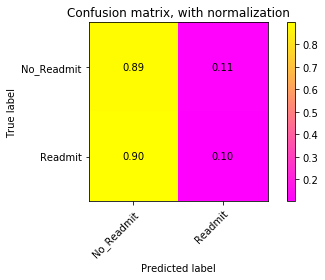

In [26]:
y_test_predict = dummy_clf.predict(X_test)
ax1 = plot_confusion_matrix(np.array(y_test), np.array(y_test_predict), classes=np.array(["No_Readmit", "Readmit"]), title="Confusion matrix, without normalization")
ax1 = plot_confusion_matrix(np.array(y_test), np.array(y_test_predict), classes=np.array(["No_Readmit", "Readmit"]), normalize=True, title="Confusion matrix, with normalization")

In [27]:
report_dict = classification_report(y_test, y_test_predict, target_names=np.array(["No_Readmit", "Readmit"]), output_dict=True)
pd.DataFrame(report_dict).transpose()

,precision,recall,f1-score,support
No_Readmit,0.889938,0.888413,0.889175,16337.000000
Readmit,0.100641,0.102051,0.101341,1999.000000
accuracy,0.802683,0.802683,0.802683,0.802683
macro avg,0.495290,0.495232,0.495258,18336.000000
weighted avg,0.803889,0.802683,0.803285,18336.000000
